In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read in cleaned train and test data; concatenate to single df
# NOTE: this data has been scaled and categorical encoded in previous notebook  

final_train_df = pd.read_csv('Data/train.csv')
final_test_df = pd.read_csv('Data/test.csv')
cl_df = pd.concat([final_train_df, final_test_df], ignore_index=True)

In [3]:
cl_df.labels.value_counts()


1    1043940
0     262416
Name: labels, dtype: int64

In [4]:
# Subset into two dataframes: charged_off(0) and fully_paid(1)

charged_off = cl_df[cl_df.labels == 0]
fully_paid = cl_df[cl_df.labels == 1]

charged_off.reset_index(inplace=True)
fully_paid.reset_index(inplace=True)

fully_paid.head()

,index,acc_now_delinq,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,dti,funded_amnt,...,verification_status_Source Verified,verification_status_Not Verified,verification_status_Verified,hardship_flag_N,hardship_flag_Y,disbursement_method_Cash,disbursement_method_DirectPay,debt_settlement_flag_N,debt_settlement_flag_Y,labels
0,1,-0.06916,0.537220,-0.675828,-0.130907,-0.896770,1.090431,-0.038715,-1.311121,-0.505232,...,0,1,0,1,0,1,0,1,0,1
1,2,-0.06916,-0.456474,0.887956,-0.766508,1.421332,1.090431,-0.038715,-0.160679,0.018340,...,1,0,0,1,0,1,0,1,0,1
2,4,-0.06916,-0.803111,-0.850328,-0.667596,0.412831,-0.429606,-0.038715,-0.679254,-1.011544,...,0,1,0,1,0,1,0,1,0,1
3,5,-0.06916,0.491001,3.582835,0.125506,-0.269177,-0.429606,-0.038715,-1.700052,1.105759,...,1,0,0,1,0,1,0,1,0,1
4,7,-0.06916,-0.063618,0.331795,-0.278204,0.372926,1.090431,-0.038715,0.434981,-0.505232,...,1,0,0,1,0,1,0,1,0,1


In [5]:
# Filter df to get only the loan_amnt column

loan_charged_off = charged_off.loan_amnt
loan_fully_paid = fully_paid.loan_amnt

loan_charged_off.head()

0    0.184093
1   -0.275992
2   -0.966120
3    1.012245
4   -0.552043
Name: loan_amnt, dtype: float64

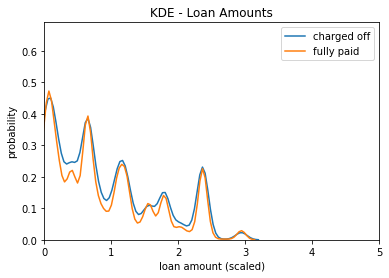

In [6]:
# Visualize the datasets using histogram \ KDE plots

ax = sns.distplot(loan_charged_off, bins=int(np.sqrt(len(charged_off))), 
                  kde=True, hist = False, label = 'charged off')
ax = sns.distplot(loan_fully_paid, bins=int(np.sqrt(len(fully_paid))), 
                  kde=True, hist = False , label = 'fully paid')
ax.set(xlabel='loan amount (scaled)', ylabel='probability', xlim = (0,5),
       title = 'KDE - Loan Amounts')

plt.show()

In [7]:
# Compute mean and variance of the two samples
loan_co_mean = np.mean(loan_charged_off)
loan_fp_mean = np.mean(loan_fully_paid)

loan_co_var = np.var(loan_charged_off)
loan_fp_var = np.var(loan_fully_paid)

print('mean of loan amount for charged off accounts =', loan_co_mean)
print('mean of loan amount for fully_paid accounts =', loan_fp_mean)

print('\nvariance of loan amount for charged off accounts =', loan_co_var)
print('variance of loan amount for fully_paid accounts =', loan_fp_var)


mean of loan amount for charged off accounts = 0.1302069983214234
mean of loan amount for fully_paid accounts = -0.03186664773276771

variance of loan amount for charged off accounts = 1.0239344377642705
variance of loan amount for fully_paid accounts = 0.9900112342208185


In [8]:
# Use scipy.stats.ttest_ind
t, p = scipy.stats.ttest_ind(loan_charged_off, loan_fully_paid, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))


ttest_ind:            t = 73.5915  p = 0


High t value indicates that the groups are different. This is reinforced by p=0 (ie, not by chance).

### Bootstrap Hypothesis Testing

In [9]:
# difference in observed mean for charged_off(0) and fully_paid(1): obs_diff_mean
obs_diff_mean = np.mean(loan_charged_off) - np.mean(loan_fully_paid)

In [10]:
np.random.seed(48)
N_rep = 10000

def draw_bs_reps(data, func, size=1):
    # initialize array
    bs_replicates = np.empty(size)
    
    # generate replicates
    for i in range(size):
        sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(sample)
        
    return bs_replicates


In [11]:
# Calculate the 95% confidence interval for the difference between the means
charged_mean_replicates = draw_bs_reps(loan_charged_off, np.mean, size=10000)
paid_mean_replicates = draw_bs_reps(loan_fully_paid, np.mean, size=10000)

bs_diff_mean = draw_bs_reps(loan_charged_off, np.mean, size=10000) - draw_bs_reps(loan_fully_paid, np.mean, size=10000)

ci_bs_mean = np.percentile(bs_diff_mean, [2.5, 97.5])

print("The 95% confidence interval for the difference between replicant charged off and fully paid accounts is: ", ci_bs_mean)

The 95% confidence interval for the difference between replicant charged off and fully paid accounts is:  [0.15773027 0.1664066 ]


#### Bootstrap Procedure Using Mean As Test Statistic

In [12]:
# Bootstrap Procedure Using Mean As Test Statistic

# Merge the two observed samples into one sample of (n + m) observations
# Draw a bootstrap sample of (n + m) observations with replacement from the merged sample.
reps = 10000

# Concatenate the data sets: data
data = np.concatenate((loan_charged_off, loan_fully_paid))
charged_bs_rep_means = np.empty(reps)
paid_bs_rep_means = np.empty(reps)
        
# generate replicates
for i in range(reps):

    # Sample with replacement the concatenated array: sampled_data
    sampled_data = np.random.choice(data, len(data))

    # Split the sampled array into two: sample_1, sample_2
    charged_sample = sampled_data[:len(loan_charged_off)]
    paid_sample = sampled_data[len(loan_charged_off):]

    # Calculate means
    charged_bs_rep_means[i] = np.mean(charged_sample)
    paid_bs_rep_means[i] = np.mean(paid_sample)

#########################    
# Calculate difference in means: diff_bs_rep_means
diff_bs_rep_means = charged_bs_rep_means - paid_bs_rep_means

# Compute p-value: p
p = np.sum(diff_bs_rep_means >= obs_diff_mean) / len(diff_bs_rep_means)

# Print the result
print('p-value =', p)


p-value = 0.0



For $\alpha$ = 0.05,

$H_0$ : There is no difference in loan amount sought between charged_off and fully_paid loans.


$H_a$ : There is a difference in loan amount sought between charged_off and fully_paid loans.

p = 0.0

We reject the null hypothesis. There is a statistical difference in loan amount sought between charged_off and fully_paid loans.



annual_inc

In [13]:
# Filter df to get only the annual_inc column

an_inc_charged_off = charged_off.annual_inc
an_inc_fully_paid = fully_paid.annual_inc

an_inc_charged_off.head()

0   -0.340928
1   -0.722229
2   -0.964875
3   -0.114458
4    0.236801
Name: annual_inc, dtype: float64

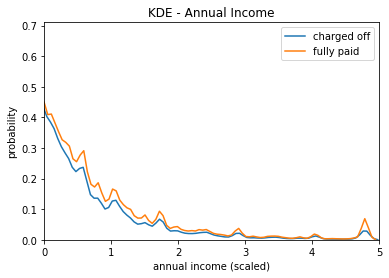

In [14]:
# Visualize the datasets using histogram \ KDE plots

ax = sns.distplot(an_inc_charged_off, bins=int(np.sqrt(len(charged_off))), 
                  kde=True, hist = False, label = 'charged off')
ax = sns.distplot(an_inc_fully_paid, bins=int(np.sqrt(len(fully_paid))), 
                  kde=True, hist = False , label = 'fully paid')
ax.set(xlabel='annual income (scaled)', ylabel='probability', xlim = (0,5),
       title = 'KDE - Annual Income')

plt.show()

In [15]:
# Compute mean and variance of the two samples
an_inc_co_mean = np.mean(an_inc_charged_off)
an_inc_fp_mean = np.mean(an_inc_fully_paid)

an_inc_co_var = np.var(an_inc_charged_off)
an_inc_fp_var = np.var(an_inc_fully_paid)

print('mean of annual income for charged off accounts =', an_inc_co_mean)
print('mean of annual income for fully_paid accounts =', an_inc_fp_mean)

print('\nvariance of annual income for charged off accounts =', an_inc_co_var)
print('variance of annual income for fully_paid accounts =', an_inc_fp_var)


mean of annual income for charged off accounts = -0.12468682384120139
mean of annual income for fully_paid accounts = 0.03187923073861866

variance of annual income for charged off accounts = 0.8436454101206241
variance of annual income for fully_paid accounts = 1.0376205908584824


In [16]:
# Use scipy.stats.ttest_ind
t, p = scipy.stats.ttest_ind(an_inc_charged_off, an_inc_fully_paid, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))


ttest_ind:            t = -76.3158  p = 0


Low t-value indicates there is no differences between groups; low p indicates that the data didn't occur by chance.

### Bootstrap Hypothesis Testing

In [17]:
# difference in observed mean for charged_off(0) and fully_paid(1): obs_diff_mean
obs_diff_mean = np.mean(an_inc_charged_off) - np.mean(an_inc_fully_paid)

In [18]:
# Calculate the 95% confidence interval for the difference between the means
charged_mean_replicates = draw_bs_reps(an_inc_charged_off, np.mean, size=10000)
paid_mean_replicates = draw_bs_reps(an_inc_fully_paid, np.mean, size=10000)

bs_diff_mean = draw_bs_reps(an_inc_charged_off, np.mean, size=10000) - draw_bs_reps(an_inc_fully_paid, np.mean, size=10000)

ci_bs_mean = np.percentile(bs_diff_mean, [2.5, 97.5])

print("The 95% confidence interval for the difference between replicant charged off and fully paid accounts is: ", ci_bs_mean)

The 95% confidence interval for the difference between replicant charged off and fully paid accounts is:  [-0.16054925 -0.15259419]


#### Bootstrap Procedure Using Mean As Test Statistic

In [19]:
# Bootstrap Procedure Using Mean As Test Statistic

# Merge the two observed samples into one sample of (n + m) observations
# Draw a bootstrap sample of (n + m) observations with replacement from the merged sample.
reps = 10000

# Concatenate the data sets: data
data = np.concatenate((an_inc_charged_off, an_inc_fully_paid))
charged_bs_rep_means = np.empty(reps)
paid_bs_rep_means = np.empty(reps)
        
# generate replicates
for i in range(reps):

    # Sample with replacement the concatenated array: sampled_data
    sampled_data = np.random.choice(data, len(data))

    # Split the sampled array into two: sample_1, sample_2
    charged_sample = sampled_data[:len(an_inc_charged_off)]
    paid_sample = sampled_data[len(an_inc_charged_off):]

    # Calculate means
    charged_bs_rep_means[i] = np.mean(charged_sample)
    paid_bs_rep_means[i] = np.mean(paid_sample)

#########################    
# Calculate difference in means: diff_bs_rep_means
diff_bs_rep_means = charged_bs_rep_means - paid_bs_rep_means

# Compute p-value: p
p = np.sum(diff_bs_rep_means >= obs_diff_mean) / len(diff_bs_rep_means)

# Print the result
print('p-value =', p)


p-value = 1.0



For $\alpha$ = 0.05,

$H_0$ : There is no difference in annual income between charged_off and fully_paid loans.


$H_a$ : There is a difference in annual income between charged_off and fully_paid loans.

p = 1.0

We keep the null hypothesis. There is no statistical difference in the annual incomes between charged_off and fully_paid loans.

